In [286]:
import pandas as pd
import numpy as np

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib import rc
rc('font', family='AppleGothic') 
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

from sklearn.metrics import silhouette_samples, silhouette_score

import math

# 군집분석

In [164]:
cus = pd.read_pickle('Customers.pkl')

In [165]:
ts = pd.read_pickle('Transactions.pkl')

In [166]:
ts.index = range(ts.shape[0])

In [167]:
data = pd.merge(ts, cus)

### Feature 생성

In [168]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [169]:
data['month'] = data['datetime'].dt.month
data['hour'] = data['datetime'].dt.hour
data['day'] = data['datetime'].dt.day_name().str[:3]

In [170]:
data['weekend'] = ["주말" if value in ['Sun', 'Sat'] else "평일" for value in data['day']]

In [171]:
id_g = data.groupby('custid')

In [174]:
cp1 = id_g.size().reset_index(name = '구매횟수')

In [175]:
cp2 = id_g.brand.nunique().reset_index(name = '구매브랜드수')

In [185]:
cp3 = id_g.corner.nunique().reset_index(name = '구매코너수')

In [178]:
cp4 = pd.crosstab(data.custid, data['weekend']).reset_index()
cp4.index.name = None
cp4.columns.name = None

In [179]:
cp4['주말비율'] = cp4.주말 / cp1.구매횟수

In [180]:
cp4.drop(['주말', '평일'], axis = 1, inplace = True)

In [182]:
cp5 = pd.crosstab(data.custid, data['import']).reset_index()
cp5.index.name = None
cp5.columns.name = None

In [183]:
cp5['수입상품비율'] = cp5.iloc[:, 2] / cp1.구매횟수

In [184]:
cp5 = cp5.iloc[:, [0, -1]]

In [187]:
cp6 = id_g.hour.mean().reset_index(name = '평균구매시간')

In [188]:
cp7 = id_g.installment.mean().reset_index(name = '평균할부개월수')

In [205]:
cp8 = id_g.datetime.agg(lambda x : (x.max() - x.min()).days).reset_index(name = '경과일수')

In [206]:
cp8['평균방문주기'] = cp8.경과일수 / cp1.구매횟수

In [219]:
cp9 = id_g.amount.mean().reset_index(name = '평균구매금액')

In [220]:
ins_cnt = pd.crosstab(data['custid'], data['installment']).reset_index()
ins_cnt.index.name = None
ins_cnt.columns.name = None

In [221]:
ins_cnt['할부구매비율'] = ins_cnt.iloc[:, 1] / ins_cnt.iloc[:, 1:].sum(axis = 1)

In [222]:
cp10 = ins_cnt.iloc[:, [0, -1]]

### Data 병합

In [223]:
df = pd.merge(cp1, cp2, how = 'left')
df = pd.merge(df, cp3, how = 'left')
df = pd.merge(df, cp4, how = 'left')
df = pd.merge(df, cp5, how = 'left')
df = pd.merge(df, cp6, how = 'left')
df = pd.merge(df, cp7, how = 'left')
df = pd.merge(df, cp8, how = 'left')
df = pd.merge(df, cp9, how = 'left')
df = pd.merge(df, cp10, how = 'left')

In [224]:
data['age'] = 2021 - data['birth'].str[:4].astype(int)

In [225]:
data = data.drop('birth', axis = 1)

### 데이터 스케일링

In [226]:
from sklearn.preprocessing import MinMaxScaler

In [227]:
scaler = MinMaxScaler()

In [260]:
data = pd.DataFrame(scaler.fit_transform(df.iloc[:, 1:]), columns = df.columns[1:], index = df.custid)

In [262]:
data.head()

,구매횟수,구매브랜드수,구매코너수,주말비율,수입상품비율,평균구매시간,평균할부개월수,경과일수,평균방문주기,평균구매금액,할부구매비율
custid,,,,,,,,,,,
16,0.038128,0.116667,0.391304,0.147059,0.184492,0.651584,0.323255,0.477901,0.168927,0.056181,0.264706
29,0.012132,0.038889,0.217391,0.894737,0.055024,0.714980,0.151500,0.464088,0.295506,0.044830,0.421053
33,0.076256,0.138889,0.478261,0.642857,0.149351,0.599084,0.144860,0.345304,0.072825,0.058841,0.517857
34,0.019064,0.077778,0.391304,0.826087,0.090909,0.705686,0.204795,0.381215,0.199953,0.052365,0.217391
50,0.041594,0.138889,0.521739,0.500000,0.000000,0.705413,0.185358,0.911602,0.305550,0.061918,0.333333


### 군집화 결과 시각화

In [258]:
def visualize_silhouette(cluster_list, X) : 

    for n_cluster in cluster_list :

        plt.xlim([-0.1, 1])
        plt.ylim([0, len(X) + (n_cluster + 1) * 10])
        clusterer = KMeans(n_clusters = n_cluster, random_state = 42)
        cluster_labels = clusterer.fit_predict(X)

        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_cluster,
              "The average silhouette_score is :", silhouette_avg)

        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_cluster):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            plt.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor = color, edgecolor = color, alpha = 0.7)

            plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10

            plt.title("The silhouette plot for the various clusters.")
            plt.xlabel("The silhouette coefficient values")
            plt.ylabel("Cluster label")
            plt.axvline(x = silhouette_avg, color = "red", linestyle = "--")
            plt.yticks([])
            plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        plt.show()

For n_clusters = 5 The average silhouette_score is : 0.5189018433401442


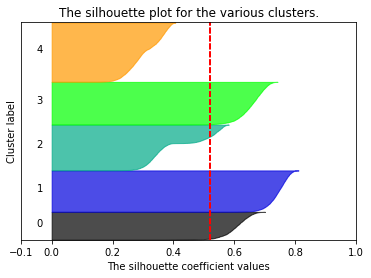

For n_clusters = 7 The average silhouette_score is : 0.6195650635665254


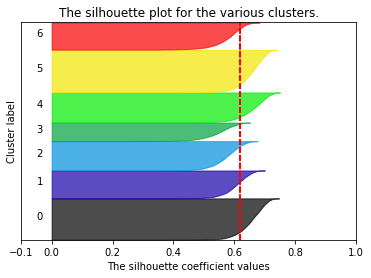

In [259]:
visualize_silhouette([5, 7], data)

군집 갯수가 7일 때 실루엣 계수가 더 높은 것을 알 수 있습니다.

이후 군집 수를 7로 설정하고 군집화를 진행합니다.

In [265]:
km = KMeans(n_clusters = 7, random_state = 42)

In [268]:
data['cluster'] = km.fit_predict(data)

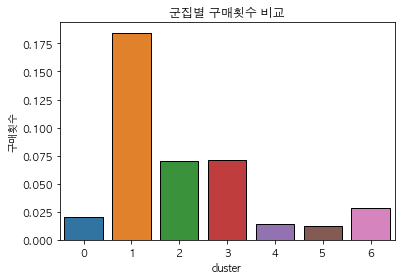

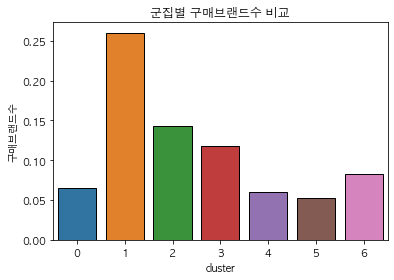

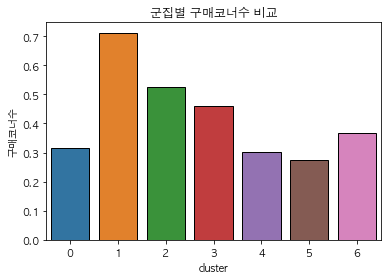

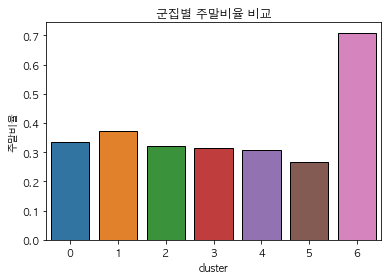

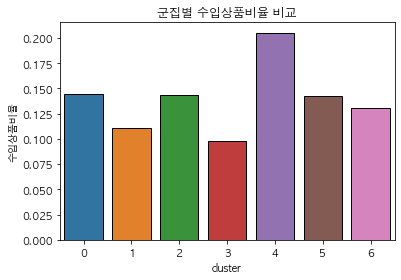

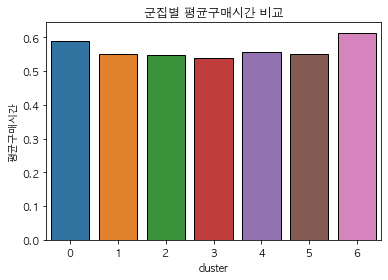

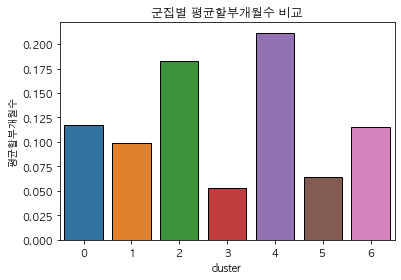

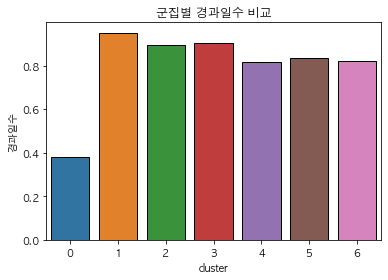

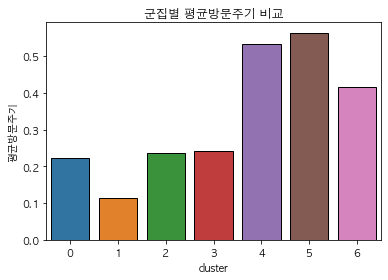

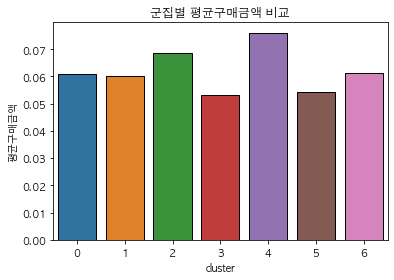

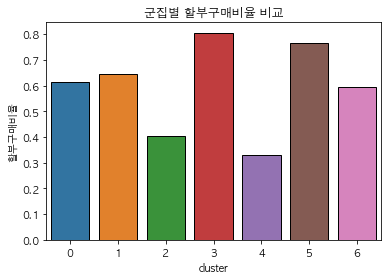

In [287]:
for col in data.columns[:-1] :
    plt.title(f'군집별 {col} 비교')
    result = data.groupby('cluster')[col].mean().reset_index()
    sns.barplot(result.cluster, result[col], edgecolor = (0, 0, 0))
    plt.show()

In [288]:
data

,구매횟수,구매브랜드수,구매코너수,주말비율,수입상품비율,평균구매시간,평균할부개월수,경과일수,평균방문주기,평균구매금액,할부구매비율,cluster
custid,,,,,,,,,,,,
16,0.038128,0.116667,0.391304,0.147059,0.184492,0.651584,0.323255,0.477901,0.168927,0.056181,0.264706,0
29,0.012132,0.038889,0.217391,0.894737,0.055024,0.714980,0.151500,0.464088,0.295506,0.044830,0.421053,6
33,0.076256,0.138889,0.478261,0.642857,0.149351,0.599084,0.144860,0.345304,0.072825,0.058841,0.517857,0
34,0.019064,0.077778,0.391304,0.826087,0.090909,0.705686,0.204795,0.381215,0.199953,0.052365,0.217391,6
50,0.041594,0.138889,0.521739,0.500000,0.000000,0.705413,0.185358,0.911602,0.305550,0.061918,0.333333,2
...,...,...,...,...,...,...,...,...,...,...,...,...
49985,0.095321,0.088889,0.478261,0.283582,0.046811,0.420742,0.062491,0.953039,0.170486,0.054857,0.761194,3
49992,0.008666,0.033333,0.217391,0.235294,0.676471,0.429261,0.015393,0.814917,0.580931,0.046659,0.941176,5
49994,0.169844,0.266667,0.565217,0.263636,0.209091,0.432821,0.443670,0.997238,0.107708,0.062512,0.245455,2



***
# 연관분석

In [142]:
def get_time(x) :
    if x <= 12 :
        return '아침'
    elif 13 <= x < 18 :
        return '오후'
    else :
        return '저녁'

In [143]:
ts['datetime'] = pd.to_datetime(ts['datetime'])

In [144]:
ts['hour'] = ts.datetime.dt.hour

In [145]:
ts['hour'] = ts['hour'].apply(get_time)

In [146]:
m = ts[ts.hour == '아침']
a = ts[ts.hour == '오후']
d = ts[ts.hour == '저녁']

In [154]:
def get_rules(data) :
    record = data.groupby('custid').corner.apply(lambda x : list(x)).reset_index()
    record['cn_cnt'] = record.corner.apply(len)
    record = record[record.cn_cnt >= 3]
    
    te = TransactionEncoder()
    te_array = te.fit_transform(record.corner)
    df = pd.DataFrame(te_array, columns = te.columns_)
    
    freq_items = apriori(df, min_support = 0.1, use_colnames = True)
    rules = association_rules(freq_items, metric = "confidence", min_threshold = .1)
    
    return freq_items, rules

In [155]:
m_f, m_rules = get_rules(m)

In [156]:
m_f

,support,itemsets
0,0.128748,(가전)
1,0.107317,(기타바이어)
2,0.294980,(니트단품)
3,0.108540,(도자기크리스탈)
4,0.224250,(문화완구)
...,...,...
76,0.110495,"(스포츠, 유아동복, 화장품)"
77,0.154824,"(스포츠, 일반식품, 화장품)"
78,0.107399,"(영캐주얼, 일반식품, 화장품)"
79,0.124919,"(일반식품, 유니캐주얼, 화장품)"


In [157]:
m_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(섬유),(니트단품),0.284795,0.294980,0.114488,0.402003,1.362812,0.030479,1.178968
1,(니트단품),(섬유),0.294980,0.284795,0.114488,0.388122,1.362812,0.030479,1.168868
2,(니트단품),(스포츠),0.294980,0.377934,0.137712,0.466851,1.235272,0.026229,1.166778
3,(스포츠),(니트단품),0.377934,0.294980,0.137712,0.364381,1.235272,0.026229,1.109186
4,(유니캐주얼),(니트단품),0.309485,0.294980,0.111473,0.360190,1.221063,0.020181,1.101919
...,...,...,...,...,...,...,...,...,...
163,"(일반식품, 화장품)",(유아동복),0.342324,0.368970,0.153276,0.447751,1.213515,0.026968,1.142654
164,"(유아동복, 화장품)",(일반식품),0.224495,0.588657,0.153276,0.682759,1.159858,0.021125,1.296624
165,(일반식품),"(유아동복, 화장품)",0.588657,0.224495,0.153276,0.260382,1.159858,0.021125,1.048521
166,(유아동복),"(일반식품, 화장품)",0.368970,0.342324,0.153276,0.415415,1.213515,0.026968,1.125031


In [158]:
a_f, a_rules = get_rules(a)

In [159]:
a_f

,support,itemsets
0,0.221465,(가전)
1,0.182008,(기타바이어)
2,0.494202,(니트단품)
3,0.182338,(도자기크리스탈)
4,0.141837,(디자이너부띠끄)
...,...,...
1215,0.103259,"(일반식품, 화장품, 니트단품, 피혁A, 섬유, 스포츠)"
1216,0.108919,"(일반식품, 유니캐주얼, 화장품, 니트단품, 영캐주얼, 스포츠)"
1217,0.100621,"(일반식품, 유니캐주얼, 화장품, 니트단품, 트래디셔널캐주얼, 스포츠)"
1218,0.102709,"(일반식품, 유니캐주얼, 화장품, 니트단품, 피혁A, 스포츠)"


In [160]:
a_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(가전),(니트단품),0.221465,0.494202,0.134033,0.605211,1.224622,0.024585,1.281185
1,(니트단품),(가전),0.494202,0.221465,0.134033,0.271211,1.224622,0.024585,1.068258
2,(가전),(섬유),0.221465,0.488707,0.130571,0.589578,1.206404,0.022339,1.245775
3,(섬유),(가전),0.488707,0.221465,0.130571,0.267176,1.206404,0.022339,1.062377
4,(가전),(스포츠),0.221465,0.574985,0.152992,0.690819,1.201456,0.025653,1.374648
...,...,...,...,...,...,...,...,...,...
13233,(유니캐주얼),"(일반식품, 화장품, 영캐주얼, 섬유, 스포츠)",0.518767,0.137715,0.103808,0.200106,1.453044,0.032366,1.077999
13234,(화장품),"(일반식품, 유니캐주얼, 영캐주얼, 섬유, 스포츠)",0.852283,0.111557,0.103808,0.121800,1.091822,0.008730,1.011664
13235,(영캐주얼),"(일반식품, 유니캐주얼, 화장품, 섬유, 스포츠)",0.450404,0.153762,0.103808,0.230478,1.498933,0.034553,1.099694
13236,(섬유),"(일반식품, 유니캐주얼, 화장품, 영캐주얼, 스포츠)",0.488707,0.151454,0.103808,0.212414,1.402504,0.029792,1.077402


In [161]:
d_f, d_rules = get_rules(d)

In [162]:
d_f

,support,itemsets
0,0.101334,(가전)
1,0.274151,(니트단품)
2,0.177159,(문화완구)
3,0.290278,(섬유)
4,0.133199,(수입명품)
...,...,...
74,0.125523,"(영캐주얼, 일반식품, 화장품)"
75,0.140177,"(일반식품, 유니캐주얼, 화장품)"
76,0.114591,"(일반식품, 유아동복, 화장품)"
77,0.104125,"(일반식품, 캐릭터캐주얼, 화장품)"


In [163]:
d_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(섬유),(니트단품),0.290278,0.274151,0.106683,0.367521,1.340580,0.027103,1.147626
1,(니트단품),(섬유),0.274151,0.290278,0.106683,0.389140,1.340580,0.027103,1.161842
2,(니트단품),(스포츠),0.274151,0.357187,0.118546,0.432410,1.210596,0.020622,1.132529
3,(스포츠),(니트단품),0.357187,0.274151,0.118546,0.331886,1.210596,0.020622,1.086415
4,(영캐주얼),(니트단품),0.294852,0.274151,0.108854,0.369182,1.346638,0.028020,1.150648
...,...,...,...,...,...,...,...,...,...
159,"(피혁A, 화장품)",(일반식품),0.159637,0.632889,0.105598,0.661486,1.045185,0.004565,1.084479
160,"(일반식품, 화장품)",(피혁A),0.352845,0.248256,0.105598,0.299275,1.205511,0.018002,1.072809
161,(피혁A),"(일반식품, 화장품)",0.248256,0.352845,0.105598,0.425359,1.205511,0.018002,1.126190
162,(일반식품),"(피혁A, 화장품)",0.632889,0.159637,0.105598,0.166850,1.045185,0.004565,1.008658
